In [8]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%reset -f
%config Completer.use_jedi = False
from platform import python_version
print(python_version())
!nvidia-smi

3.6.8
Sat Sep 25 14:22:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GRID V100D-32Q      On   | 00000000:02:00.0 Off |                  N/A |
| N/A   N/A    P0    N/A /  N/A |   3601MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
import os
import math
import copy
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import random_split, DataLoader
import statistics
from tqdm import tqdm
import torchvision

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
    
class StopExecution(Exception):
    def _render_traceback_(self):
        pass
    
def stop():
    raise StopExecution

cuda:0


In [10]:
# Change root_dir to your directory, MNIST should download itself

transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])
    
root_dir = "/data/s2967057/MNIST/"
train = torchvision.datasets.MNIST(root=root_dir, train=True, download=True, transform=transforms)
test = torchvision.datasets.MNIST(root=root_dir, train=False, download=True, transform=transforms)

params = {'batch_size': 64,
          'shuffle': True,
          'num_workers': 6,
          'pin_memory': True}

trainloader = DataLoader(train, **params)
testloader = DataLoader(test, **params)

In [11]:
'''
These are the boolean conceptor operations. Adopted directly from Jaeger's 2017 report. 
NB: these operations work only on conceptors with singular values between 0 and 1, 
which is completely fine for this project. If you want to use them for other matrices use the 
operations defined in terms of the svd, also explained in Jaeger 2017, adopted by Xu He found here:
https://github.com/he-xu/CAB/blob/master/logic.py
'''

def NOT(C):
    dim = C.shape[0]
    not_C = np.eye(dim) - C
    return not_C

def AND(C, B, tol = 1e-14):
    dim = C.shape[0]
    C_and_B = np.linalg.inv(np.linalg.inv(C) + np.linalg.inv(B) - np.eye(dim))
    return C_and_B

def OR(R, Q):
    R_or_Q = NOT(AND(NOT(R), NOT(Q)))
    return R_or_Q
    
def plot_spectrum(S):
    x = np.linspace(0,S.shape[0],S.shape[0])
    plt.autoscale(True)
    plt.plot(x, S)
    plt.show()

def conceptor(X, alpha=4):
    R = (X.T).dot(X) / X.shape[0]
    U, S, _ = np.linalg.svd(R)
    S_C = (np.diag(S).dot(np.linalg.inv(np.diag(S) + alpha ** (-2) * np.eye(X.shape[1]))))
    plot_spectrum(np.diag(S_C))
    C = U.dot(S_C).dot(U.T)
    return C, S, np.diag(S_C)

In [12]:
# Parameters for kernel size and padding
k = 5
p = 2

'''
All the operations are done by hand, because this made it easier to get activations without having to use hooks and 
allowed for using a weight matrix which is the sum of a constant matrix and a variable matrix.
First two layers are conv. layers. To get an idea of how this works when done without using
conv2d: https://pytorch.org/docs/stable/generated/torch.nn.Unfold.html
Essentially a conv. layer is implemented by flattening patches of an image, flattening the weight filter 
and performing a multiplication. Unfold does the flattening with consideration for kernel size, padding, stride and such.
In this case weight filters don't need to flattened as they are initialized flat.
'''
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # w1, w2 are conv. layers 
        self.w1 = nn.Parameter(torch.empty((k*k*1, 16)))
        self.w2 = nn.Parameter(torch.empty((k*k*16, 32)))
        # w3, w4 linear layers
        self.w3 = nn.Parameter(torch.empty((7*7*32, 7*7*16)))        
        self.w4 = nn.Parameter(torch.empty((7*7*16, 1)))
        
        self.w1_old = nn.Parameter(torch.zeros((k*k*1, 16), requires_grad=False))
        self.w2_old = nn.Parameter(torch.zeros((k*k*16, 32), requires_grad=False))
        self.w3_old = nn.Parameter(torch.zeros((7*7*32, 7*7*16), requires_grad=False))
        self.w4_old = nn.Parameter(torch.zeros((7*7*16, 1), requires_grad=False))
        self.act = nn.ReLU()
        
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        # only the incremental weights are changed
        self.weights = [self.w1, self.w2, self.w3, self.w4]
        
        # used for multi-head
        self.head = []
        
    def forward(self, x):
        self.x0 = F.unfold(x, k, 1, p, 1).transpose(1,2)
        # conv operation
        self.x1 = F.relu(self.x0.matmul(self.w1 + self.w1_old)).transpose(1,2)
        self.x1 = self.x1.view(self.x1.shape[0], 16, 28, 28)
        self.x1 = self.pool(self.x1)
        self.x1 = F.unfold(self.x1, k, 1, p, 1).transpose(1,2)
        # conv operation, flattened afterwards to perform linear operation
        self.x2 = F.relu(self.x1.matmul(self.w2 + self.w2_old)).transpose(1,2)
        self.x2 = self.x2.view(self.x2.shape[0], 32, 28//2, 28//2)
        self.x2 = self.pool(self.x2)
        self.x2 = torch.flatten(self.x2, 1)

        self.x3 = F.relu(self.x2.matmul(self.w3 + self.w3_old))
        
        self.x4 = self.x3.matmul(self.w4 + self.w4_old)
        return torch.squeeze(self.x4)
    
    def initialise(self):
        nn.init.xavier_uniform_(self.w1, gain=nn.init.calculate_gain('relu'))
        nn.init.xavier_uniform_(self.w2, gain=nn.init.calculate_gain('relu'))
        nn.init.xavier_uniform_(self.w3, gain=nn.init.calculate_gain('relu'))    
        nn.init.xavier_uniform_(self.w4, gain=nn.init.calculate_gain('sigmoid'))      

    
model = Net().to(device)
model.initialise()

ce_loss = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.weights)

# /2 instead of sqrt for speed. Also done in Xu He paper, works just as well
def l2_norm(x):
    return torch.sum(torch.pow(x, 2)) / 2

# l2 weight decay
def l2_loss(params):
    loss = 0
    for p in params:
        loss += l2_norm(p)
    return loss

'''
Conceptor regularization by pseudo-rehearsal. Details on this regularization in Xu He 2018 
https://marcpickett.com/cl2018/CL-2018_paper_55.pdf
Here defined for convolutions. Essentialy: perform forward pass with new weights and old weights
take the difference and multiply with conceptor. Because it's a conv operation, activation map
has to be "unfolded" again before multiplying with conceptor
'''
def c_loss(m, c1, c2, c3):
    # Pseudo-rehearsal, so create noise tensor
    noise1 = torch.cuda.FloatTensor(model.x0.shape).normal_()
    # Old weights activation
    a_old1 = F.relu(noise1.matmul(m.w1_old)).transpose(1,2)  
    # New weights activation
    a_new1 = F.relu(noise1.matmul(m.w1 + m.w1_old)).transpose(1,2)
#     a_old1 = F.max_pool2d(a_old1.view(a_old1.shape[0], 16, 28, 28), kernel_size=2)
#     a_new1 = F.max_pool2d(a_new1.view(a_new1.shape[0], 16, 28, 28), kernel_size=2)

    # Take diff of activations, reshape to multiply with conceptor
    # Doing .view before unfold is required, because unfold only works with properly sized
    # activation maps
    diff1 = (a_new1 - a_old1).view(a_new1.shape[0],16,28,28)
    diff1 = F.unfold(diff1, k, 1, p, 1).transpose(1,2)
    diff1 = diff1.matmul(c1)
    reg1 = l2_norm(diff1)
    
    # Same as before, but here difference is flattened, because next layer is a linear layer
    noise2 = torch.cuda.FloatTensor(model.x1.shape).normal_()
    a_old2 = F.relu(noise2.matmul(m.w2_old)).transpose(1,2)  
    a_new2 = F.relu(noise2.matmul(m.w2 + m.w2_old)).transpose(1,2)
    a_old2 = F.max_pool2d(a_old2.view(a_old2.shape[0], 32, 28//2, 28//2), kernel_size=2)
    a_new2 = F.max_pool2d(a_new2.view(a_new2.shape[0], 32, 28//2, 28//2), kernel_size=2)
    diff2 = (a_new2 - a_old2)
    diff2 = torch.flatten(diff2, 1)
    diff2 = diff2.matmul(c2)
    reg2 = l2_norm(diff2)
    
    # Conceptor regularization for linear layer. Same as for conv. layer, but without the 
    # reshaping stuff
    noise3 = torch.cuda.FloatTensor(model.x2.shape).normal_()
    a_old3 = F.relu(noise3.matmul(m.w3_old)) 
    a_new3 = F.relu(noise3.matmul(m.w3 + m.w3_old))
    diff3 = a_new3 - a_old3
    diff3 = diff3.matmul(c3)
    reg3 = l2_norm(diff3)

    loss = reg1 + reg2 + reg3
    return loss

In [13]:
num_tasks = 10
# Accuracy on a single task, pass task number [0,9]
def task_accuracy(task):
    correct = 0
    total = 0
    for x,y in testloader:
        x,y = x.to(device), y.to(device)
        y = F.one_hot(y,10)
        y = y[:,task]
        model(x.float())
        out = torch.squeeze(model.x3.matmul(model.head[task]))
        gts = torch.greater(out, 0.5).int()
        eqs = gts == y
        correct += sum(eqs.int())
        total += len(eqs)
    return correct/total*100


#Accuracy on all tasks
def overall_accuracy():
    model.w4_old = nn.Parameter(torch.zeros(model.w4_old.shape, device=device))
    correct = 0
    total = 0
    for x,y in testloader:
        x,y = x.to(device), y.to(device)
        outs = []
        for i in range(num_tasks):
            model.w4 = nn.Parameter(model.head[i])
            out = model(x.float())
            outs.append(torch.unsqueeze(out,dim=1))
        out = torch.cat(outs, dim=1)
        eqs = y == torch.argmax(out, dim=1)
        correct += sum(eqs.int())
        total += len(eqs)
    return correct/total*100

Task 1


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.09440603567513703


 50%|█████     | 1/2 [00:07<00:07,  7.82s/it]

Test/validation loss: 0.007125764152936131
Train loss: 0.03965829581077864


100%|██████████| 2/2 [00:15<00:00,  7.81s/it]

Test/validation loss: 0.0038450215205366304


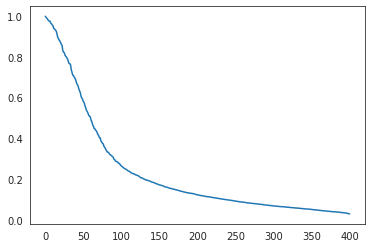

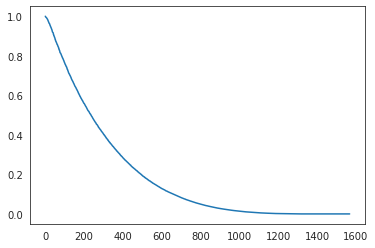

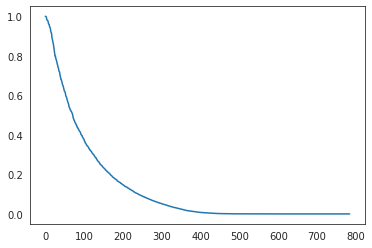

Generating results
task 1 accuracy: tensor(99.8800, device='cuda:0')
Task 2


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 4992309.488567816


 50%|█████     | 1/2 [00:17<00:17, 17.41s/it]

Test/validation loss: 0.005999604846698612
Train loss: 1000.4617664198886


100%|██████████| 2/2 [00:34<00:00, 17.42s/it]

Test/validation loss: 0.0054905967881727314


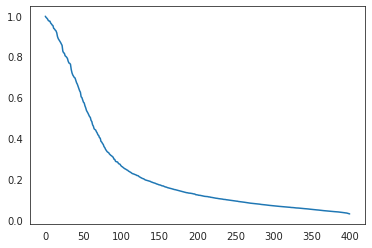

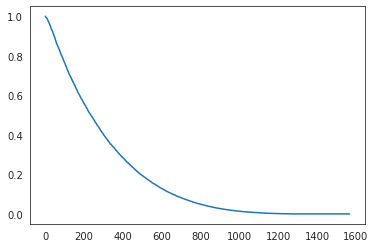

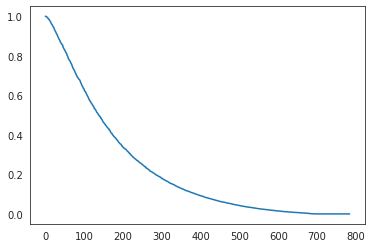

Generating results
task 1 accuracy: tensor(99.8200, device='cuda:0')
task 2 accuracy: tensor(98.5100, device='cuda:0')
Task 3


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 7154329.393117095


 50%|█████     | 1/2 [00:17<00:17, 17.45s/it]

Test/validation loss: 0.00943462468482032
Train loss: 497.89716583121816


100%|██████████| 2/2 [00:34<00:00, 17.44s/it]

Test/validation loss: 0.007939638715099461


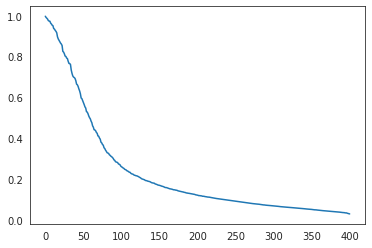

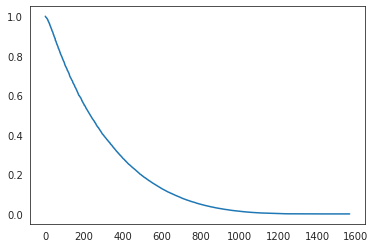

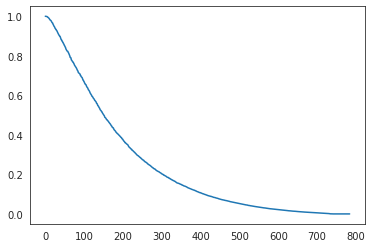

Generating results
task 1 accuracy: tensor(99.8500, device='cuda:0')
task 2 accuracy: tensor(99.8000, device='cuda:0')
task 3 accuracy: tensor(98.8100, device='cuda:0')
Task 4


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 8578933.104944127


 50%|█████     | 1/2 [00:17<00:17, 17.51s/it]

Test/validation loss: 0.015329166275547717
Train loss: 216.61464559396447


100%|██████████| 2/2 [00:34<00:00, 17.49s/it]

Test/validation loss: 0.011036374496172218


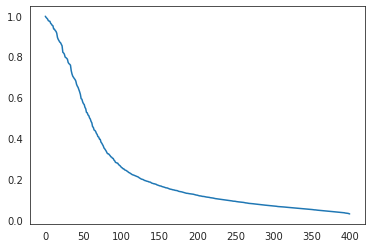

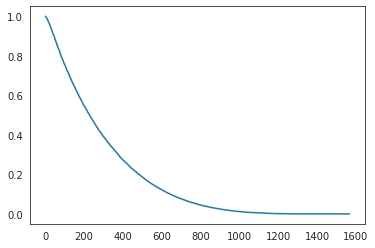

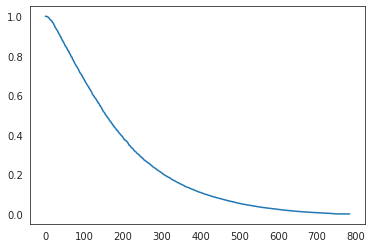

Generating results
task 1 accuracy: tensor(99.8500, device='cuda:0')
task 2 accuracy: tensor(99.8200, device='cuda:0')
task 3 accuracy: tensor(99.2800, device='cuda:0')
task 4 accuracy: tensor(98.5200, device='cuda:0')
Task 5


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 9946950.021980643


 50%|█████     | 1/2 [00:17<00:17, 17.41s/it]

Test/validation loss: 0.009110842108471425
Train loss: 122.17234107426235


100%|██████████| 2/2 [00:34<00:00, 17.41s/it]

Test/validation loss: 0.007514236919870333


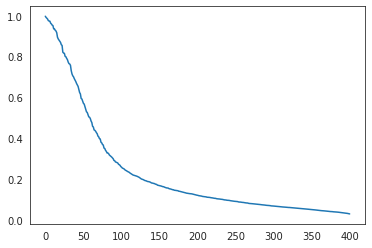

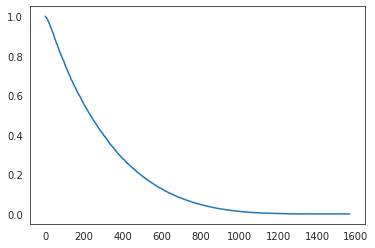

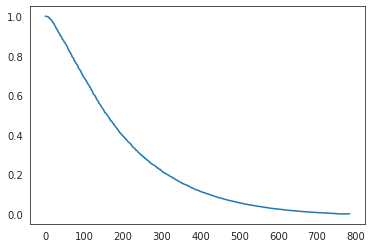

Generating results
task 1 accuracy: tensor(99.8100, device='cuda:0')
task 2 accuracy: tensor(99.8000, device='cuda:0')
task 3 accuracy: tensor(98.6400, device='cuda:0')
task 4 accuracy: tensor(97.1700, device='cuda:0')
task 5 accuracy: tensor(99.2200, device='cuda:0')
Task 6


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 12947130.456122197


 50%|█████     | 1/2 [00:17<00:17, 17.42s/it]

Test/validation loss: 0.044243805923137314
Train loss: 79.80158750233112


100%|██████████| 2/2 [00:34<00:00, 17.42s/it]

Test/validation loss: 0.03022664572130058


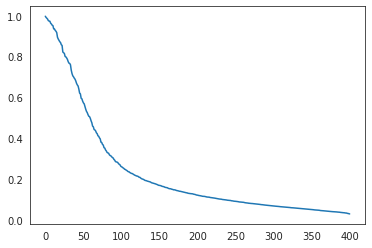

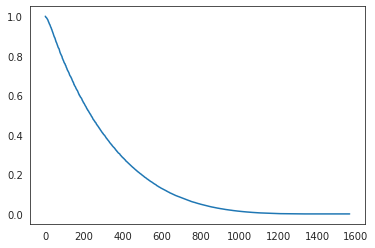

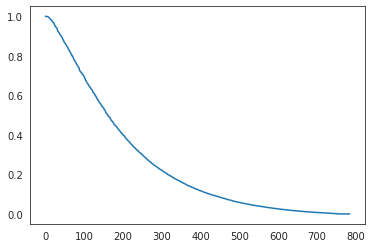

Generating results
task 1 accuracy: tensor(99.8800, device='cuda:0')
task 2 accuracy: tensor(99.8100, device='cuda:0')
task 3 accuracy: tensor(99.2400, device='cuda:0')
task 4 accuracy: tensor(99.2400, device='cuda:0')
task 5 accuracy: tensor(99.6700, device='cuda:0')


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/s2967057/MasterThesis/env/lib64/python3.6/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-064c303ffba4>", line 101, in <module>
    acc = task_accuracy(j)
  File "<ipython-input-13-50c9dafc92ce>", line 6, in task_accuracy
    for x,y in testloader:
  File "/home/s2967057/MasterThesis/env/lib64/python3.6/site-packages/torch/utils/data/dataloader.py", line 355, in __iter__
    return self._get_iterator()
  File "/home/s2967057/MasterThesis/env/lib64/python3.6/site-packages/torch/utils/data/dataloader.py", line 301, in _get_iterator
    return _MultiProcessingDataLoaderIter(self)
  File "/home/s2967057/MasterThesis/env/lib64/python3.6/site-packages/torch/utils/data/dataloader.py", line 914, in __init__
    w.start()
  File "/usr/lib64/python3.6/multiprocessing/process.py", line 105, in start
    self._popen = self._Popen(self)
  File "/us

TypeError: object of type 'NoneType' has no len()

In [14]:
# time.sleeps are there to prevent tqdm from messing up the output formatting, can be removed
epochs = 2
weight_decay = 9 * 10e-6 # lambda in paper
c_decay = 10e1 # gamma in paper
results = []
for i in range(num_tasks):
    results.append([])
    print("Task", i+1)
    time.sleep(0.25)
    for epoch in tqdm(range(epochs)):
        train_loss = []
        test_loss = []
        for x, y in trainloader:
            x, y = x.to(device), y.to(device)
            y = F.one_hot(y,10)
            # We are only interested in label of current task
            y = y[:,i]
            optimizer.zero_grad()
            out = model(x.float())
            # Training process for first task is normal, after that use conceptor regularization
            if i != 0:
                loss = ce_loss(out.float(), y.float()) + weight_decay * l2_loss(model.weights) + c_decay * c_loss(model, A1, A2, A3)
            else:
                loss = ce_loss(out.float(), y.float()) + weight_decay * l2_loss(model.weights)
            train_loss.append(loss.item())
            loss.backward()
            optimizer.step()
        print("Train loss:",statistics.mean(train_loss))

        for x, y in testloader:
            x, y = x.to(device), y.to(device)
            y = F.one_hot(y,10)
            y = y[:,i]
            optimizer.zero_grad()
            out = model(x.float())
            loss = ce_loss(out.float(), y.float())
            test_loss.append(loss.item())
        print("Test/validation loss:",statistics.mean(test_loss))
    
    time.sleep(0.25)
        
    # Collect activation batches to compute conceptors
    col1 = []
    col2 = []
    col3 = []
    for _ in range(20):
        x,y = next(iter(trainloader))
        model(x.to(device))
        col1.append(model.x1)
        col2.append(model.x2)
        col3.append(model.x3)
        
    '''
    Compute the actual conceptors.
    For conv. layer (C1) this is done by taking patches of the activation map and computing the autocorrelation matrix 
    from those patches. But we want to do this over multiple images. Therefore, input patches are concatenated into 
    one big matrix
    For the linear layers (C2, C3) it's simpler, just take the activation vectors and put them as columns in an array.
    '''
    C1, _, _ = conceptor(torch.cat([torch.cat(list(c)) for c in col1], dim=0).cpu().detach().numpy())
    C2, _, _ = conceptor(torch.cat(col2, dim=0).cpu().detach().numpy())
    C3, _, _ = conceptor(torch.cat(col3, dim=0).cpu().detach().numpy())

    # Do the OR operation after every task to compute subspace used for all tasks currently trained on
    if i == 0:
        A1 = torch.zeros(C1.shape)
        A2 = torch.zeros(C2.shape)
        A3 = torch.zeros(C3.shape)
        A1 = OR(C1, A1.numpy())
        A2 = OR(C2, A2.numpy())
        A3 = OR(C3, A3.numpy())

    else:
        A1 = OR(C1, A1.cpu().detach().numpy())
        A2 = OR(C2, A2.cpu().detach().numpy())
        A3 = OR(C3, A3.cpu().detach().numpy())
        
    
    # Conceptors are calculated using numpy, because their linalg library was (is?) more advanced, not sure if it still is, so
    # could be changed to torch code for minor speed up
    A1 = torch.from_numpy(A1).to(device).float()
    A2 = torch.from_numpy(A2).to(device).float()
    A3 = torch.from_numpy(A3).to(device).float()
        
    # The incremental weights and old weights are added and will now be the old weights
    if i < num_tasks - 1:
        old1 = copy.deepcopy(model.w1.data) + copy.deepcopy(model.w1_old.data)
        old2 = copy.deepcopy(model.w2.data) + copy.deepcopy(model.w2_old.data)
        old3 = copy.deepcopy(model.w3.data) + copy.deepcopy(model.w3_old.data)
        old4 = copy.deepcopy(model.w4.data) + copy.deepcopy(model.w4_old.data)

        model.w1_old = nn.Parameter(old1)
        model.w2_old = nn.Parameter(old2)
        model.w3_old = nn.Parameter(old3)
        model.w4_old = nn.Parameter(old4)
        
        model.head.append(old4)
        
        print("Generating results")
        for j in range(i+1):
            acc = task_accuracy(j)
            print("task", j+1, "accuracy:", acc)
            results[j].append(acc)
        
        model.initialise()
    else:
        old4 = copy.deepcopy(model.w4.data) + copy.deepcopy(model.w4_old.data)
        model.head.append(old4)
        print("Generating results")
        for j in range(i+1):
            acc = task_accuracy(j)
            print("task", j+1, "accuracy:", acc)
            results[j].append(acc)

In [29]:
overall_accuracy()

tensor(97.5900, device='cuda:0')